In [78]:
import sys
import os
import json
import argparse
from typing import Any, Dict, List, Tuple
import torch

from holdem.utils import Logger, set_global_seed
from holdem.environment import Env, num_actions, state_shape
from holdem.environment.game import HoldemGameState

from benchmark.agents import create_agent

from tqdm import tqdm


In [79]:
def get_config(args)->Dict[str, Any]:
    print(f"Loading config from {args.config}")
    with open(args.config, "r") as f:
        config:Dict[str, Any] = json.load(f)
    config_dump_path = os.path.join(args.logdir, args.name, "config.json")
    config['save_dir'] = os.path.dirname(config_dump_path)
    os.makedirs(config['save_dir'], exist_ok=True)
    with open(config_dump_path, "w") as f:
        json.dump(config, f, indent=4)
    return config

In [80]:
def create_game(config: Dict[str, Any]) -> Tuple[Env, List]:
    agents = [
        create_agent(agent_config["agent"], **agent_config["args"])
        for agent_config in config["agents"]
    ]
    num_players = len(agents)
    seed = config["settings"].get("seed", 3407)
    __env_config: Dict[str, Any] = {"num_players": num_players, "seed": seed}
    set_global_seed(seed=seed)
    env = Env(**__env_config, agents=agents)
    return env, agents


In [81]:
def run_game(config: Dict[str, Any]):

    total_rounds = config["settings"].get("total_rounds", 1000)
    env, agents = create_game(config=config)

    trajectories_list = []
    payoffs_list = []

    for episode in tqdm(range(total_rounds)):
        trajectories, payoffs = env.run(is_training=True)
        trajectories_list.append(trajectories)
        payoffs_list.append(payoffs)
        # print("### Trajectories ###")
        # print(trajectories)
        # print("###    Payoff    ###")
        # print(payoffs)
    return trajectories_list, payoffs_list

In [82]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--config",
    type=str,
    default="benchmark/config/game_random+dqn.json",
)
parser.add_argument(
    "--logdir",
    type=str,
    default="experiments",
)
parser.add_argument(
    "--name",
    type=str,
    default="test",
)

args = parser.parse_args(
    ["--config", "benchmark\config\game_rulebased200+rulebased500.json", "--name", "rulebased200+rulebased500"]
)
config = get_config(args=args)

Loading config from benchmark\config\game_rulebased200+rulebased500.json


In [83]:
trajectories_list, payoffs_list = run_game(config)

100%|██████████| 1000/1000 [00:32<00:00, 30.65it/s]


In [84]:
from matplotlib import pyplot as plt
import numpy as np

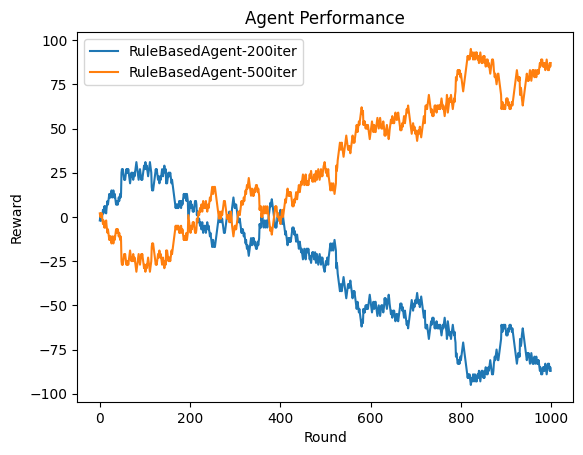

In [85]:
def plot_payoffs(config:Dict[str, Any], payoffs_list:List[List[float]], output_image:str|None= None) -> None:
    payoff_array = np.array(payoffs_list)
    payoff_array = np.cumsum(payoff_array, axis=0)
    for idx, agent_config in enumerate(config['agents']):
        plt.plot(payoff_array[:,idx], label=agent_config['name'])
    plt.xlabel('Round')
    plt.ylabel('Reward')
    plt.title('Agent Performance')
    plt.legend()
    if output_image:
        plt.savefig(output_image)
    plt.show()

plot_payoffs(config=config, payoffs_list=payoffs_list, output_image=os.path.join(config['save_dir'], 'reward.png'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


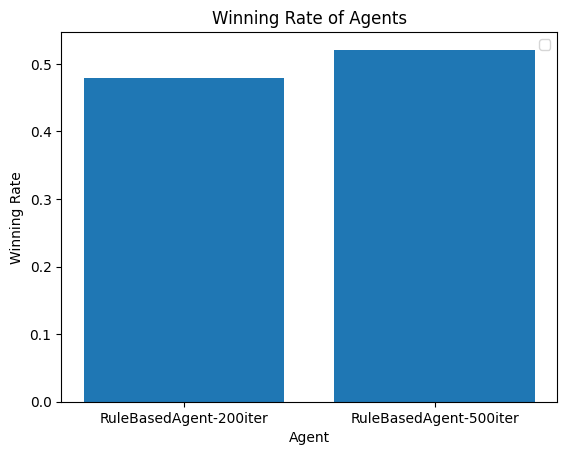

In [97]:
def plot_winning_rate(config:Dict[str, Any], payoffs_list:List[List[float]], output_image:str|None= None) -> None:
    winner_array = np.array(payoffs_list).argmax(axis=1)
    winning_rates = np.zeros(len(config['agents']))
    names = []
    for idx, agent_config in enumerate(config['agents']):
        names.append(agent_config['name'])
        winning_rates[idx] = (winner_array == idx).sum()
    winning_rates /= config['settings']['total_rounds']
    plt.bar(names, winning_rates)
    plt.xlabel('Agent')
    plt.ylabel('Winning Rate')
    plt.title('Winning Rate of Agents')
    plt.legend()
    if output_image:
        plt.savefig(output_image)
    plt.show()

plot_winning_rate(config=config, payoffs_list=payoffs_list, output_image=os.path.join(config['save_dir'], 'winning_rate.png'))